# Klasyfikatory

### Pakiety

In [3]:
import pandas as pd 
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import random
import warnings 
warnings.filterwarnings('ignore')

In [4]:
from xgboost import XGBClassifier

### Ustawienie ziarna gwarantuje reprodukowalność wyników

In [3]:
np.random.seed(123)

### Wczytanie danych

In [4]:
data = pd.read_csv('australia.csv')
data = pd.DataFrame(data)

### Sprawdzenia zrównoważenia zbioru ze względu na zmienną celu, w celu doboru odpowiednich miar oceny klasyfikacji

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f518032a390>]],
      dtype=object)

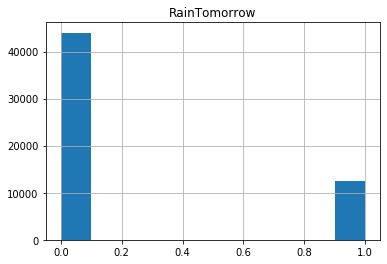

In [5]:
data.filter(["RainTomorrow"]).hist()

Dane są niezrównoważone, więc jako miary jakości predykcji klasy przez klasyfikatory będziemy używać precision i recall (nie accuracy)

# 1. Podział na zbiory treningowy i testowy  

* 80% obserwacji należy do zbioru treningowego, pozostałe do testowego.  
* Odseparowujemy zmienną celu od zmiennych objaśniających.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop('RainTomorrow', axis=1), data['RainTomorrow'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Klasyfikatory

## 2.1. Random Forest

In [7]:
# Stworzenie modelu
rf_classifier = RandomForestClassifier(n_estimators=1000, max_depth=8, max_features='sqrt', bootstrap=True, 
                                       min_samples_leaf=2, min_samples_split=2, random_state=42)


### Objaśnienie wybranych hiperparametrów

Wybrane hiperparametry:  

**n_estimators** - ilość drzew składowych (int, domyślnie 100)  
**max_depth** - maksymalna głębokość drzewa (int, domyślnie None)   
**min_samples_split** - minimalna liczba obserwacji wymagana do podziału węzła wewnętrznego (int/float, domyślnie 2)  
**min_samples_leaf** - minimalna liczba obserwacji wymagana względem liścia (int, domyślnie 1)  
**max_features** - ilość cech branych pod uwagę podczas poszukiwania najlepszego podziału (string). Jeśli “sqrt”, to max_features=sqrt(n_features), jeśli “log2”, to max_features=log2(n_features).  
**bootstrap** - stosowanie bootstrap (bool, domyślnie True)  
**random_state** - kontroluje losowość procedury bootstrap   

In [8]:
# Trenowanie modelu
rf_classifier.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [9]:
# Predykcja klasy
predict_class1 = rf_classifier.predict(X_test)

# Predykcja prawdopodobieństwa
predict_proba1 = rf_classifier.predict_proba(X_test)[:, 1]

## 2.2. XGBoost

In [10]:
# Stworzenie modelu
xgb_classifier = XGBClassifier(n_estimators = 1000, booster = 'gbtree', colsample_bytree = 0.8, max_depth = 5, 
                               gamma = 1.5, min_child_weight = 1, subsample = 0.8, random_state = 42)


### Objaśnienie wybranych hiperparametrów

**booster** - typ boostera, gbtree, gblinear lub dart. Dwa pierwsze oparte na modelach drzewiastych, ostatni na funkcjach liniowych.   
**colsample_bytree** - to frakcja kolumn (losowo wybranych), które zostaną wykorzystane przy konstruowaniu każdego drzewa.  
**gamma** - odpowiada za częstość przycinania drzewa, im wyższa gamma, tym częściej przycinamy.   
**min_child_weight** - minimalna waga wymagana względem 'dziecka'  
**subsample** - odpowiada części obserwacji (wierszy) do podpróbkowania na każdym etapie. Domyślnie jest ustawiony na 1, co oznacza, że używamy wszystkich wierszy.    
Pozostałe jak wyżej.

In [11]:
# Trenowanie modelu
xgb_classifier.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [12]:
# Predykcja klasy
predict_class2 = xgb_classifier.predict(X_test)

# Predykcja prawdopodobieństwa
predict_proba2 = xgb_classifier.predict_proba(X_test)[:, 1]

## 2.3. Regresja logistyczna

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
# Budowanie modelu
lr_classifier = LogisticRegression(penalty = 'l1', class_weight='balanced', C = 0.01, solver = 'saga')

### Objaśnienie wybranych hiperparametrów

**penalty** - norma kary.   
**class_weight** - wagi klas.  
**C** - odwrotny parametr regularyzacji, wyższe wartości C odpowiadają mniejszej regularyzacji.   
**solver** - algorytm używany w procedurze optymalizacji.  

In [15]:
lr_classifier.fit(X_train, Y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# Predykcja klasy
predict_class3 = lr_classifier.predict(X_test)

# Predykcja prawdopodobieństwa
predict_proba3 = lr_classifier.predict_proba(X_test)[:, 1]

# 3. Zestawienie rezultatów

## 3.1. Miary precision i recall
Wartości miary recall na zbiorze testowym dla klasyfikatorów Random Forest, XGBoost i regresji logistycznej wynoszą odpowiednio:


In [17]:
pd.DataFrame({"Metoda" : ["Random Forest", "XGBoost", "Regresja logistyczna"], 
             "Recall" : [recall_score(Y_test, predict_class1), recall_score(Y_test, predict_class2), recall_score(Y_test, predict_class3)],
             "Precision" : [precision_score(Y_test, predict_class1, average='macro'), precision_score(Y_test, predict_class2, average='macro'), precision_score(Y_test, predict_class3, average='macro')]})

,Metoda,Recall,Precision
0,Random Forest,0.469144,0.823449
1,XGBoost,0.572536,0.798576
2,Regresja logistyczna,0.796123,0.738254


## Krzywe Precision-Recall

Text(0.5, 1.0, 'Krzywa Precision-Recall dla regresji logistycznej')

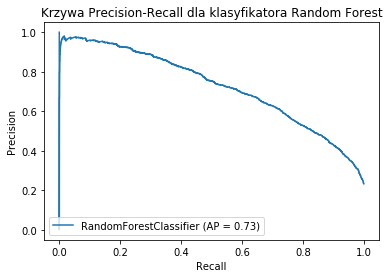

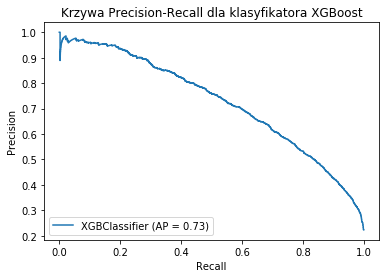

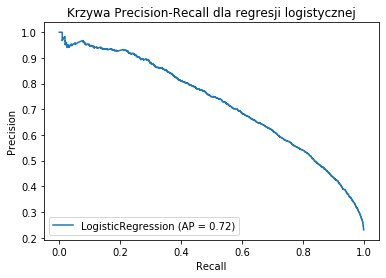

In [18]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp1 = plot_precision_recall_curve(rf_classifier, X_test, Y_test)
disp1.ax_.set_title('Krzywa Precision-Recall dla klasyfikatora Random Forest')
disp2 = plot_precision_recall_curve(xgb_classifier, X_test, Y_test)
disp2.ax_.set_title('Krzywa Precision-Recall dla klasyfikatora XGBoost')
disp3 = plot_precision_recall_curve(lr_classifier, X_test, Y_test)
disp3.ax_.set_title('Krzywa Precision-Recall dla regresji logistycznej')

## Wnioski:
Przy predykcji klasy okazuje się, że osiągnięte przez klasyfikatory wartości precision i recall są zróżnicowane. Względem miary precision najlepsze rezultaty osiągnął Random Forest, natomiast względem recall regresja logistyczna.  

Moim zdaniem, ocena który klasyfikator jest lepszy od pozostałych zależy od konkretnej sytuacji i zmiennej celu, którą chcemy przewidywać. Mianowicie ważne jest to, czy chcemy aby klasyfikator wykrywał jak największą frakcję wyników dodatnich (maksymalizacja recall), czy aby jak największa część obserwacji wskazanych przez klasyfikator jako dodatnia faktycznie taka była (maksymalizacja precision).  
W przypadku przewidywania deszczu, skupiłabym się bardziej na zmiennej recall.  

## 3.2. Krzywa ROCR i miara AUC

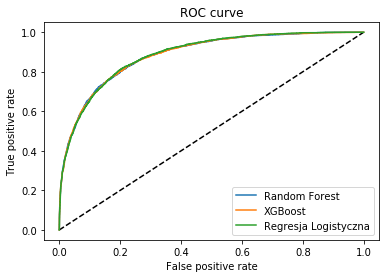

In [19]:
# Krzywa ROCR
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, predict_proba1) # false & true positive rates
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_test, predict_proba2) # false & true positive rates
fpr3, tpr3, thresholds3 = metrics.roc_curve(Y_test, predict_proba3) # false & true positive rates

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='Random Forest')
plt.plot(fpr2, tpr2, label='XGBoost')
plt.plot(fpr3, tpr3, label='Regresja Logistyczna')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [20]:
# Miara AUC
pd.DataFrame({"Klasyfikator" : ["Random Forest", "XGBoost", "Regresja Logistyczna"],
             "AUC": [metrics.auc(fpr1, tpr1), metrics.auc(fpr2, tpr2), metrics.auc(fpr3, tpr3)]})

,Klasyfikator,AUC
0,Random Forest,0.886290
1,XGBoost,0.886197
2,Regresja Logistyczna,0.887379


## Wnioski

Rezultaty osiągnięte przez klasyfikatory w przypadku predykcji prawdopodobieństwa są niemalże identyczne (krzywe ROCR pokrywają się) i dość wysokie. Jak widać najwyższy wynik względem miary AUC osiągnęła regresja logistyczna, nie mniej jednak, różnice są znikome. Jak wynika z literatury, wyniki wszystkich klasyfikatorów świadczą o tym, że każdy z nich może być postrzegany jako co najmniej dobry, a nawet bardzo dobry.

# Część dodatkowa - model regresyjny

# Regresja liniowa

In [16]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Wczytanie danych

In [17]:
df = pd.read_csv('allegro-api-transactions.csv')
df = pd.DataFrame(df)
df = df.drop(['lp', 'date'], axis = 1)

Y = df.price
cols = ['categories', 'seller','it_location', 'main_category']

## 1. Target Encoding

In [18]:
te = ce.TargetEncoder(cols = cols)

In [25]:
# Podział na zbiory treningowy i testowy
train_X1, test_X1, train_Y1, test_Y1 = train_test_split(df.drop('price', axis=1), df['price'])

# Kodowanie po podziale na podzbiory
encoded_train_X1 = te.fit_transform(train_X1, train_Y1)
encoded_test_X1 = te.transform(test_X1, test_Y1)


# Model
linreg1 = LinearRegression()
linreg1.fit(encoded_train_X1, train_Y1)

# Predykcja
y_pred1 = linreg1.predict(encoded_test_X1)

## 2. James Stein Encoding

In [26]:
js = ce.james_stein.JamesSteinEncoder(df, cols = cols)

In [27]:
# Podział na zbiory treningowy i testowy
train_X2, test_X2, train_Y2, test_Y2 = train_test_split(df.drop('price', axis=1), df['price'])

# Kodowanie po podziale na podzbiory
encoded_train_X2 = js.fit_transform(train_X2, train_Y2)
encoded_test_X2 = js.transform(test_X2, test_Y2)


# Model
linreg2 = LinearRegression()
linreg2.fit(encoded_train_X2, train_Y2)

# Predykcja
y_pred2 = linreg2.predict(encoded_test_X2)

## 3. CatBoost Encoding

In [28]:
cb = ce.CatBoostEncoder(cols = cols)

In [29]:
# Podział na zbiory treningowy i testowy
train_X3, test_X3, train_Y3, test_Y3 = train_test_split(df.drop('price', axis=1), df['price'])

# Kodowanie po podziale na podzbiory
train_X3_copy = train_X3.copy()
train_Y3_copy = train_Y3.copy()
test_X3_copy = test_X3.copy()
test_Y3_copy = test_Y3.copy()

## Losowa permutacja wierszy (zabieg zalecane w dokumentacji)
train_permutation = np.random.permutation(len(train_X3_copy)) 
train_X3_copy = train_X3_copy.iloc[train_permutation].reset_index(drop = True)
train_Y3_copy = train_Y3_copy.iloc[train_permutation].reset_index(drop = True)

test_permutation = np.random.permutation(len(test_X3_copy)) 
test_X3_copy = test_X3_copy.iloc[test_permutation].reset_index(drop = True)
test_Y3_copy = test_Y3_copy.iloc[test_permutation].reset_index(drop = True)

## Kodowanie
encoded_train_X3 = cb.fit_transform(train_X3_copy, train_Y3_copy)
encoded_test_X3 = cb.transform(test_X3_copy, test_Y3_copy)


# Model
linreg3 = LinearRegression()
linreg3.fit(encoded_train_X3, train_Y3_copy)

# Predykcja
y_pred3 = linreg3.predict(encoded_test_X3)

## Zestawienie wyników

In [30]:
pd.DataFrame({"Metoda" : ["Target Encoding", "James Stein Encoding", "CatBoost Encoding"], 
             "R2" : [r2_score(test_Y1, y_pred1), r2_score(test_Y2, y_pred2), r2_score(test_Y3_copy, y_pred3)],
             "RMSE" : [mean_squared_error(test_Y1, y_pred1, squared=False), mean_squared_error(test_Y2, y_pred2, squared=False), mean_squared_error(test_Y3_copy, y_pred3, squared=False)]})

,Metoda,R2,RMSE
0,Target Encoding,0.106129,390.000356
1,James Stein Encoding,0.145902,334.230796
2,CatBoost Encoding,0.225271,212.388148


## Wnioski

Zgodnie z początkową intuicją rezultaty regresji względem rozważanych miar, dla danych poddanych podobnym metodom kodowania zmiennych kategorycznych, są zróżnicowane w nieznacznym stopniu. 

Pierwsze co rzuca się w oczy w powyższych wynikach, to niskie wartości współczynników determinacji. Wartość R<sup>2</sup> wynosząca ok. 0.1-0.15, gdzie maksymalna możliwa wartość wynosi 1, jest niezwykle mała. Pokazuje, że nasze modele regresji praktycznie nie przedstawiają zmienności próbki. Wartości błędów średniokwadratowych dla rozważanych encodingów są nieco bardziej zróżnicowane. 

Nie mniej jednak w tym wywołaniu, najlepiej względem obydwu miar wypadł CatBoost Encoding. (Odnoszę się do konkretnego wywołania, ponieważ wyniki nie są ściśle reprodukowalne)